In [1]:
import pandas as pd

# Chargement
df1 = pd.read_csv('vols_aplatis_BON.csv')
df2 = pd.read_csv('vols_aplatis_R.csv')

# Prétraitement
df1['is_attack'] = df1['is_attack'].fillna(0)  # Remplir les NaN
df2['is_attack'] = df2['is_attack'].astype(int)  # Convertir en entier

# Fusion
df_merged = pd.concat([df1, df2], ignore_index=True)
df_merged['mission_id'] = df_merged['mission_id'].astype(int)

# Sauvegarde
df_merged.to_csv('missions_fusionnees.csv', index=False)

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Charger les données
df = pd.read_csv('missions_fusionnees.csv')

# 2. Générer la liste des colonnes time_0 à time_20
time_cols = [f'time_{i}' for i in range(21)]

# 3. Supprimer les colonnes non pertinentes
cols_to_drop = ['mission_id', 'is_attack'] + time_cols
features = df.drop(columns=cols_to_drop)
target = df['is_attack']

# 4. Convertir les colonnes non numériques en numériques (ex: True/False → 1/0)
features = features.replace({'True': 1, 'False': 0})
features = features.apply(pd.to_numeric, errors='coerce')  # convertit ou met NaN si c’est pas possible

# 5. Remplacer les NaN (optionnel : ici on les met à 0)
features = features.fillna(0)

# 6. Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 7. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_csv('missions_fusionnees.csv')

In [5]:
df=df.drop(columns=['mission_id'],axis=1) 

Valeurs manquantes après imputation: 0

=== Performance du modèle ===
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        83
         1.0       0.72      0.84      0.77        51

    accuracy                           0.81       134
   macro avg       0.80      0.82      0.81       134
weighted avg       0.83      0.81      0.82       134

Accuracy: 0.8134


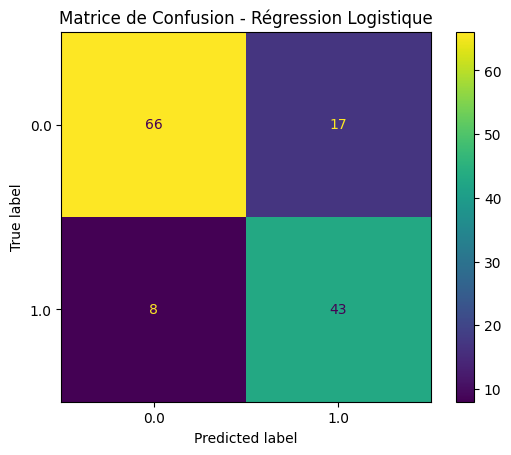

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_csv('missions_fusionnees.csv')



# 3. Sélection des features
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack'] + time_cols, axis=1, errors='ignore')

# 4. Conversion en valeurs numériques et gestion des NaN
features = features.apply(pd.to_numeric, errors='coerce')

# 5. Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')  # Alternative: 'median' ou 'most_frequent'
features_imputed = imputer.fit_transform(features)

# 6. Vérification des NaN restants
print("Valeurs manquantes après imputation:", np.isnan(features_imputed).sum())

# 7. Split des données
X_train, X_test, y_train, y_test = train_test_split(
    features_imputed, 
    df['is_attack'], 
    test_size=0.3, 
    random_state=42,
    stratify=df['is_attack']
)

# 8. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Modèle Logistic Regression avec gestion d'erreurs
try:
    lr = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
    lr.fit(X_train_scaled, y_train)
    
    # 10. Évaluation
    y_pred = lr.predict(X_test_scaled)
    
    print("\n=== Performance du modèle ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
    disp.plot()
    plt.title("Matrice de Confusion - Régression Logistique")
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'entraînement: {str(e)}")
    print("\nVérifiez que:")
    print("1. Toutes les colonnes sont numériques")
    print("2. Il n'y a pas de valeurs NaN dans les données")
    print("3. La target ne contient que 0 et 1")

Dimensions initiales: (444, 443)
Dimensions après nettoyage: (444, 443)

Optimisation de LogisticRegression...
Meilleurs paramètres: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Score F1 (validation): 0.7735

Optimisation de RandomForest...
Meilleurs paramètres: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Score F1 (validation): 0.9107


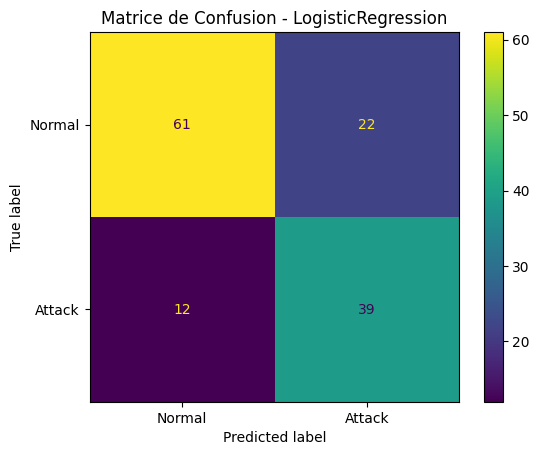

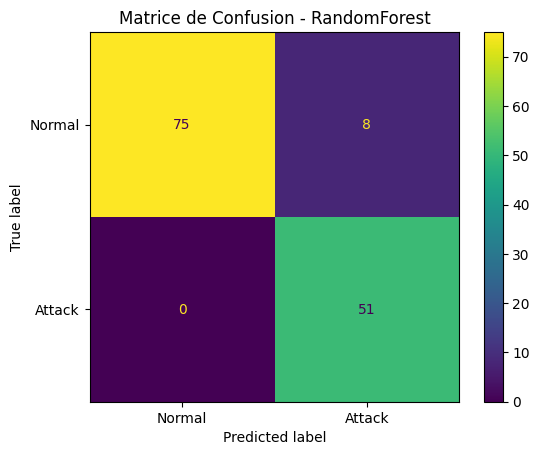

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline

# 1. Chargement et inspection des données
df = pd.read_csv('missions_fusionnees.csv')
print("Dimensions initiales:", df.shape)
def clean_data(df):
    # Conversion des booléens
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)
    
    # Conversion des chaînes de caractères
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            df[col] = df[col].replace({'True':1, 'False':0, 'true':1, 'false':0})
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                df.drop(col, axis=1, inplace=True)
    return df

df = clean_data(df)
print("Dimensions après nettoyage:", df.shape)

# 3. Feature Engineering
def create_features(df):
    # Exemples de nouvelles features
    for i in range(20):
        if f'ax_{i}' in df.columns and f'ay_{i}' in df.columns and f'az_{i}' in df.columns:
            df[f'accel_norm_{i}'] = np.sqrt(df[f'ax_{i}']**2 + df[f'ay_{i}']**2 + df[f'az_{i}']**2)
        if f'velocity_{i}' in df.columns:
            df[f'velocity_diff_{i}'] = df[f'velocity_{i}'] - df['velocity_0']
    
    # Moyennes mobiles
    for var in ['ax', 'ay', 'az']:
        for i in range(10,20):
            cols = [f'{var}_{j}' for j in range(i-5,i) if f'{var}_{j}' in df.columns]
            if cols:
                df[f'{var}_mean_last5_{i}'] = df[cols].mean(axis=1)
    return df

df = create_features(df)

# 4. Préparation des données
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack','erreur_m'] + time_cols, axis=1, errors='ignore')
target = df['is_attack']

# 5. Pipeline de prétraitement
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = preprocessor.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42, stratify=target)

# 6. Optimisation des modèles (sans XGBoost)
models = {
    'LogisticRegression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    }
}

best_models = {}
for name, config in models.items():
    print(f"\nOptimisation de {name}...")
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Meilleurs paramètres: {grid.best_params_}")
    print(f"Score F1 (validation): {grid.best_score_:.4f}")

# 7. Évaluation comparative
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else [0]*len(X_test)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall'],
        'F1': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'],
        'ROC AUC': roc_auc_score(y_test, y_prob) if hasattr(model, "predict_proba") else None
    })
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Attack'])
    disp.plot()
    plt.title(f"Matrice de Confusion - {name}")
    plt.show()

# Affichage des résultats

In [8]:

best_models['RandomForest'].fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200)

In [9]:
best_models['RandomForest'].score(X_test,y_test)
y_pred = model.predict(X_test)
classification_report(y_test,y_pred, output_dict=True)


{'0.0': {'precision': 1.0,
  'recall': 0.9036144578313253,
  'f1-score': 0.9493670886075949,
  'support': 83.0},
 '1.0': {'precision': 0.864406779661017,
  'recall': 1.0,
  'f1-score': 0.9272727272727272,
  'support': 51.0},
 'accuracy': 0.9402985074626866,
 'macro avg': {'precision': 0.9322033898305084,
  'recall': 0.9518072289156627,
  'f1-score': 0.9383199079401611,
  'support': 134.0},
 'weighted avg': {'precision': 0.9483936250948647,
  'recall': 0.9402985074626866,
  'f1-score': 0.9409580406368616,
  'support': 134.0}}

=== SVM ===
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91        83
         1.0       0.81      0.94      0.87        51

    accuracy                           0.90       134
   macro avg       0.89      0.90      0.89       134
weighted avg       0.90      0.90      0.90       134

Accuracy: 0.8955223880597015


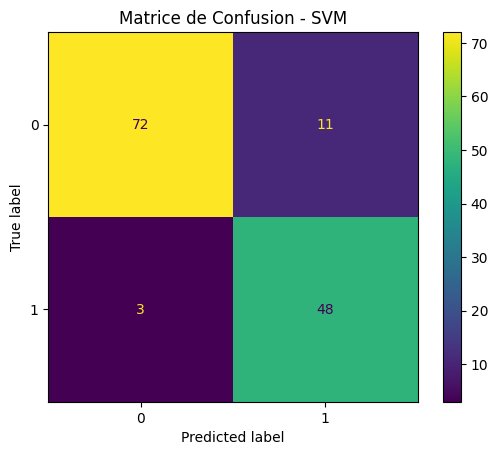

In [10]:
from sklearn.svm import SVC

# Modèle SVM
svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

# Évaluation
print("=== SVM ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matrice de Confusion - SVM")
plt.show()

Meilleurs paramètres: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Meilleur score (validation): 0.8592

=== Performance du modèle KNN ===
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.85        55
         1.0       0.73      0.88      0.80        34

    accuracy                           0.83        89
   macro avg       0.82      0.84      0.83        89
weighted avg       0.85      0.83      0.83        89

Accuracy: 0.8315


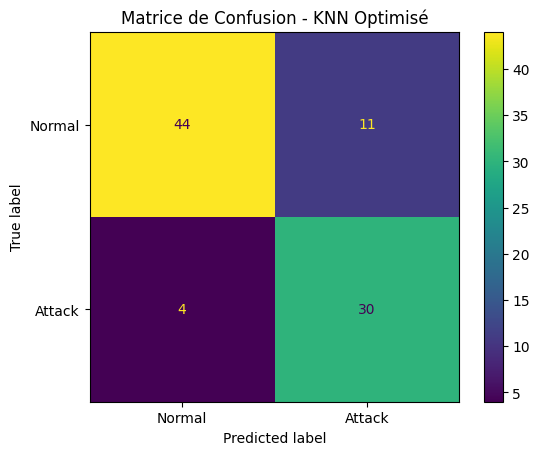

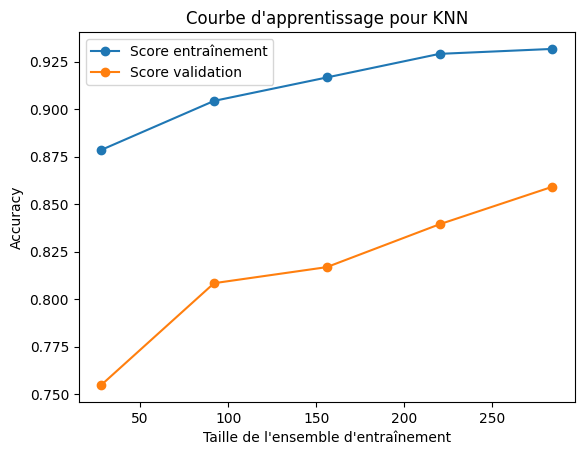

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier  # Import manquant ajouté ici
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt






# 3. Préparation des features
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack','erreur_m'] + time_cols, axis=1, errors='ignore')
features = features.apply(pd.to_numeric, errors='coerce')

# 4. Gestion des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# 5. Split des données
X_train, X_test, y_train, y_test = train_test_split(
    features_imputed, 
    df['is_attack'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['is_attack']
)

# 6. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Optimisation du KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# 8. Meilleur modèle
best_knn = grid.best_estimator_
print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Meilleur score (validation): {grid.best_score_:.4f}")

# 9. Évaluation
y_pred = best_knn.predict(X_test_scaled)
print("\n=== Performance du modèle KNN ===")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 10. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot()
plt.title("Matrice de Confusion - KNN Optimisé")
plt.show()

# 11. Courbe d'apprentissage (optionnel)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy')

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Score entraînement")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Score validation")
plt.title("Courbe d'apprentissage pour KNN")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.legend()
plt.show()